In [1]:
# DATA CLEANING
import pandas as pd
df = pd.read_csv('events.csv')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from datetime import datetime
df['date'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
df.head()

,timestamp,visitorid,event,itemid,transactionid,date
0,1433221332117,257597,view,355908,NaN,2015-06-02 07:02:12.117
1,1433224214164,992329,view,248676,NaN,2015-06-02 07:50:14.164
2,1433221999827,111016,view,318965,NaN,2015-06-02 07:13:19.827
3,1433221955914,483717,view,253185,NaN,2015-06-02 07:12:35.914
4,1433221337106,951259,view,367447,NaN,2015-06-02 07:02:17.106


In [2]:
####  TABLEAU TRANSACTIONS - EVENTS #####
# Créer 2 tableaux transaction et non transaction
non_transactions = df
transactions = df.loc[df.event == "transaction"]

# Merger les deux tableaux sur visitorid
inner_merged_total = pd.merge(transactions, non_transactions, on=["visitorid"], how="inner")

# Trier le tableau mergé par visitorid, date d'event, itemid
inner_merged_total = inner_merged_total.sort_values(by=['visitorid','date_y','itemid_x'])

# Calculer le time-diff entre transaction est event et le convertir en second
inner_merged_total['event_diff_second'] = inner_merged_total['date_x'] - inner_merged_total['date_y']
inner_merged_total['event_diff_second'] = inner_merged_total['event_diff_second'] / np.timedelta64(1, 's')

# Limiter en 24h
transaction_24h = inner_merged_total.loc[inner_merged_total['event_diff_second'] < 86400]
transaction_made_24h = transaction_24h.loc[inner_merged_total['itemid_x'] == inner_merged_total['itemid_y']]

# Supprimer certaines colonnes
transaction_made_24h = transaction_made_24h.drop(['timestamp_x','timestamp_y','transactionid_y'], axis=1)

# Supprimer des events après transactions 
transaction_made_24h = transaction_made_24h.loc[transaction_made_24h.event_diff_second >= 0]
transaction_made_24h

# VERIFICATION
#transaction_made_24h.loc[transaction_made_24h.transactionid_x == 9725]



,visitorid,event_x,itemid_x,transactionid_x,date_x,event_y,itemid_y,date_y,event_diff_second
10906025,172,transaction,10034,9725.0,2015-08-15 03:29:01.686,view,10034,2015-08-15 02:49:12.998,2388.688
10906024,172,transaction,10034,9725.0,2015-08-15 03:29:01.686,addtocart,10034,2015-08-15 02:50:16.912,2324.774
10905985,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:06:38.438,1342.792
10905996,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:39.691,921.539
10905993,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:48.324,912.906
...,...,...,...,...,...,...,...,...,...
10554877,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 01:03:14.670,490.954
10554878,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,addtocart,360922,2015-08-05 01:05:35.724,349.900
10554883,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,transaction,360922,2015-08-05 01:11:25.624,0.000
11786291,1407398,transaction,218917,10009.0,2015-07-07 05:47:15.969,addtocart,218917,2015-07-07 05:34:38.082,757.887


In [33]:
### TABLEAU TIME SUM TRANSACTIONS ###

# Créer un tableau avec transactionid, visitorid et date d'evenement
calcul_time = pd.DataFrame(transaction_made_24h,columns=['transactionid_x','visitorid','date_y'])

# Calculer time diff entre le 1er evenemnt et la transaction (== le dernier evenemnt)
g = calcul_time.groupby('transactionid_x', group_keys=False)
time_sum_tran = pd.DataFrame(g['date_y'].apply(lambda x: (x.iat[-1] - x.iat[0])/ np.timedelta64(1, 's')))
time_sum_tran = time_sum_tran.rename(columns={"date_y": "sum_time_second"})

# Convertir second en minute et en heure
time_sum_tran['sum_time_minute'] = round(time_sum_tran['sum_time_second']/60)
time_sum_tran['sum_time_hour'] = round(time_sum_tran['sum_time_second']/3600,2)
time_sum_tran

# VERIFICATION
#transaction_made_24h.loc[transaction_made_24h.transactionid_x == 17648]
#transaction_made_24h.loc[transaction_made_24h.transactionid_x == 9725]

,sum_time_second,sum_time_minute,sum_time_hour
transactionid_x,,,
0.0,530.511,9.0,0.15
1.0,559.408,9.0,0.16
2.0,189.096,3.0,0.05
3.0,0.000,0.0,0.00
4.0,299.570,5.0,0.08
...,...,...,...
17667.0,430.500,7.0,0.12
17668.0,159.337,3.0,0.04
17669.0,156.841,3.0,0.04


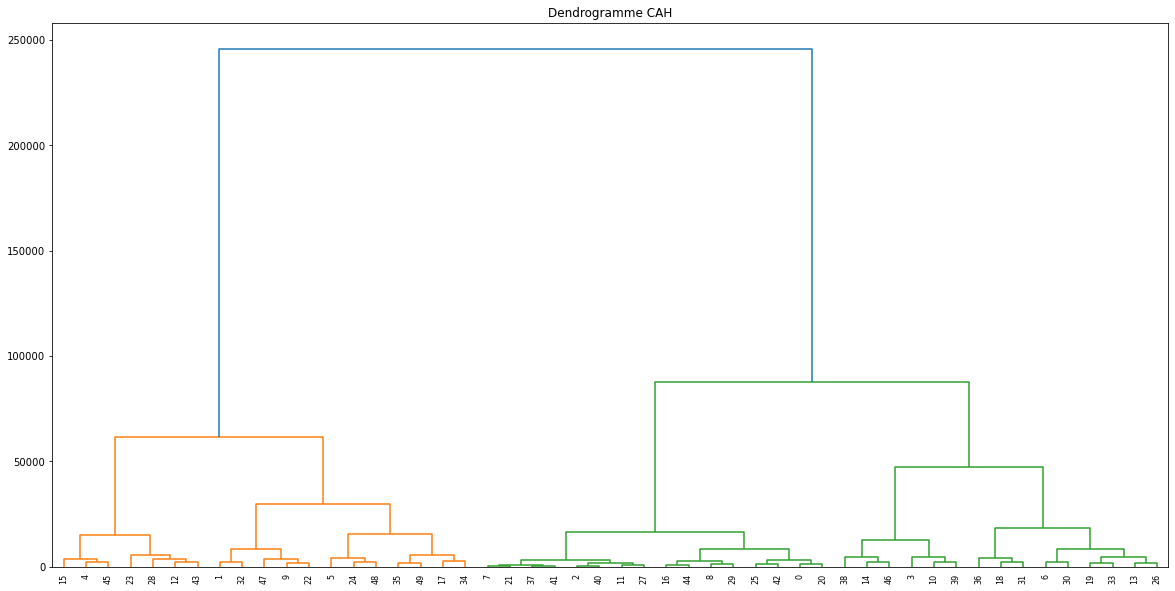

/Users/sooyounglee/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,sum_time_second,sum_time_minute,sum_time_hour,kmean1_label,agglo_label,kmean2_label
transactionid_x,,,,,,
0.0,530.511,9.0,0.15,37,2.0,2
1.0,559.408,9.0,0.16,37,2.0,2
2.0,189.096,3.0,0.05,21,2.0,2
3.0,0.000,0.0,0.00,21,2.0,2
4.0,299.570,5.0,0.08,7,2.0,2
...,...,...,...,...,...,...
17667.0,430.500,7.0,0.12,7,2.0,2
17668.0,159.337,3.0,0.04,21,2.0,2
17669.0,156.841,3.0,0.04,21,2.0,2


In [49]:
#### CLUSTERING SUR LE TABLEAU CI-DESSUS : TIME SUM TRANSACTIONS ####
k1 = KMeans(n_clusters=50).fit(time_sum_tran)
plt.figure(figsize=(20, 10))
Z = linkage(k1.cluster_centers_, method='ward', metric='euclidean')
plt.title("Dendrogramme CAH")
dendrogram(Z, leaf_rotation=90.)
plt.show()

# Agglo par 3
ac = AgglomerativeClustering(n_clusters = 3).fit(k1.cluster_centers_)
cd = pd.DataFrame(k1.cluster_centers_)

time_sum_tran['kmean1_label'] = k1.labels_

# Ajouter la colonne agglo_label
for i in list(cd.index):
    time_sum_tran.loc[time_sum_tran['kmean1_label'] == cd.index[i], 'agglo_label'] = ac.labels_[i]

# Get new centroids = mean of 3 labels from Agglo
new_centroids = time_sum_tran.groupby('agglo_label').mean()
new_time_sum_tran = time_sum_tran.drop(['agglo_label'], axis=1)

k2 = KMeans(n_clusters=3, init=new_centroids)
k2.fit(new_time_sum_tran)

# Centroids and labels
k2_centroids = k2.cluster_centers_
k2_labels = k2.labels_

# Ajouter la colonne kmean2_label
time_sum_tran['kmean2_label'] = k2.labels_
time_sum_tran

Text(0.5, 1.0, 'Clustering ')

<Figure size 1080x432 with 0 Axes>

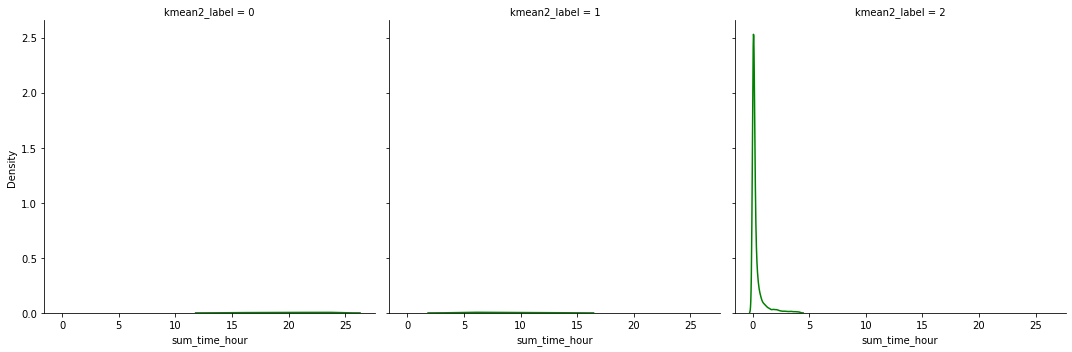

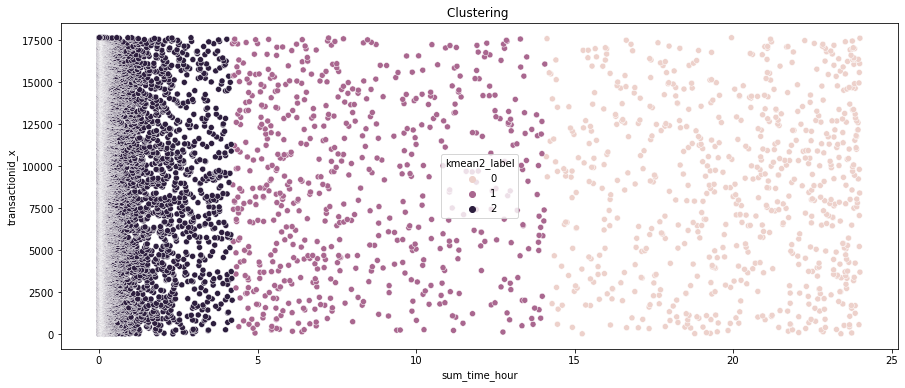

In [51]:
plt.figure(figsize=(15,6))
sns.displot(data=time_sum_tran, x="sum_time_hour", col="kmean2_label", kind="kde", color='green')

import seaborn as sns
plt.figure(figsize=(15,6))
sns.scatterplot(data=time_sum_tran, x="sum_time_hour", y=time_sum_tran.index, hue="kmean2_label")
plt.title('Clustering ')

Text(0.5, 1.0, 'Le temps nécessaire à la transaction pour avoir lieu égale à moins de 10 minutes')

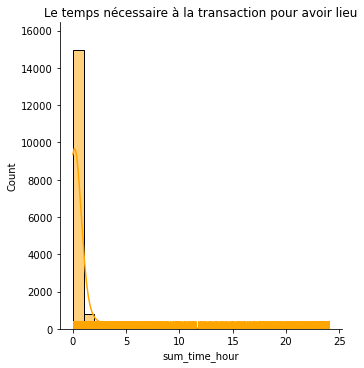

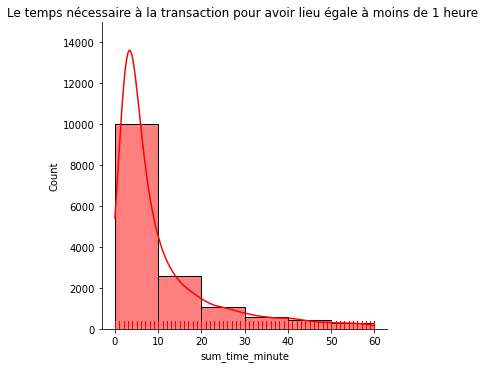

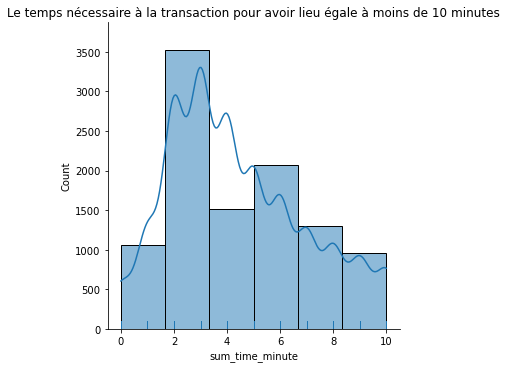

In [45]:
##### DATAVIZ ######
# Temps de Transactions moins d'une heure
sum_tran_1h = time_sum_tran.loc[round(time_sum_tran['sum_time_minute']) <= 60]

# Temps de transactions moins de 10 minutes
sum_trans_10min = sum_tran_1h.loc[round(sum_tran_1h['sum_time_minute']) <= 10]

sns.displot(time_sum_tran['sum_time_hour'], bins=24, kde=True, rug=True, color='orange')
plt.title('Le temps nécessaire à la transaction pour avoir lieu')

sns.displot(sum_tran_1h['sum_time_minute'], bins=6, kde=True, rug=True, color='red')
plt.title('Le temps nécessaire à la transaction pour avoir lieu égale à moins de 1 heure ')
          
sns.displot(sum_trans_10min['sum_time_minute'], bins=6, kde=True, rug=True)
plt.title('Le temps nécessaire à la transaction pour avoir lieu égale à moins de 10 minutes')

In [34]:
## TABLEAU TIME SUM PAR VISITEURS ###
# Calculer le sum des evenements par transaction
v = calcul_time.groupby('visitorid', group_keys=False)
time_sum_visitor = pd.DataFrame(v['date_y'].apply(lambda x: (x.iat[-1] - x.iat[0])/ np.timedelta64(1, 's')))
time_sum_visitor = time_sum_visitor.rename(columns={"date_y": "sum_time_second"})
time_sum_visitor

# Convertir second en minute et en heure
time_sum_visitor['sum_time_minute'] = round(time_sum_visitor['sum_time_second']/60)
time_sum_visitor['sum_time_hour'] = round(time_sum_visitor['sum_time_second']/3600,2)
time_sum_visitor

,sum_time_second,sum_time_minute,sum_time_hour
visitorid,,,
172,2388.688,40.0,0.66
186,400.517,7.0,0.11
264,1532.878,26.0,0.43
419,7525.939,125.0,2.09
539,216.985,4.0,0.06
...,...,...,...
1406787,168.285,3.0,0.05
1406981,261.665,4.0,0.07
1407070,608.335,10.0,0.17


In [35]:
##### TABLEAU STATS PAR VISITEURS ####
# Nombre de visites
stats = df.groupby('visitorid').agg({'visitorid':'count'})
stats = stats.rename(columns={"visitorid": "nb_visites"})

# Nombre de views par visitorid
view = df.loc[df['event'] == 'view'].groupby('visitorid').agg({'visitorid':'count'})
view = view.rename(columns={"visitorid": "nb_views"})

# Nombre de addtocarts par visitorid
addtocart = df.loc[df['event'] == 'addtocart'].groupby('visitorid').agg({'visitorid':'count'})
addtocart = addtocart.rename(columns={"visitorid": "nb_addtocarts"})

#### STATS PAR VISITEUR #####
# Nombre de transactions par visitorid
transaction = df.loc[df['event']=='transaction'].groupby(by=['visitorid','transactionid'], as_index=False).agg({'itemid': 'count'})
all_transaction=transaction.groupby(by='visitorid').agg({'transactionid': 'count'}).rename(columns={"transactionid": "nb_transactions"})

# Merge les dataframes
stats = pd.merge(stats, view, left_index=True, right_index=True, how='left')
stats = pd.merge(stats, addtocart, left_index=True, right_index=True, how='left')
stats = pd.merge(stats, all_transaction, left_index=True, right_index=True, how='left')

# Merge items
items = df.loc[df['transactionid'] > 0].groupby(by='visitorid').agg({'itemid': 'count'})
stats = pd.merge(stats, items, left_index=True, right_index=True, how='left')
stats = stats.rename(columns={"itemid": "nb_items_bought"})

# Merge avec temps moyen passé
stats = pd.merge(stats, time_sum_visitor, left_index=True, right_index=True, how='left')
stats = stats.fillna(0)
stats = stats.sort_values('nb_transactions', ascending=False)

# Supprimer le visiteur 1150086
stats = stats.drop(stats.head(1).index)
stats = stats.sort_values('sum_time_minute', ascending=False)

# Temps moyen transaction 
stats['mean_time_tran_sec'] = stats['sum_time_second'] / stats['nb_transactions']
stats = stats.fillna(0)
stats['mean_time_tran_minute'] = round(stats['mean_time_tran_sec']/60)
stats['mean_time_tran_hour'] = round(stats['mean_time_tran_sec']/3600,2)

# VERIFICATION
#stats.loc[stats.mean_time_tran_sec < 0]

stats

,nb_visites,nb_views,nb_addtocarts,nb_transactions,nb_items_bought,sum_time_second,sum_time_minute,sum_time_hour,mean_time_tran_sec,mean_time_tran_minute,mean_time_tran_hour
visitorid,,,,,,,,,,,
1165148,858,802.0,29.0,23.0,27.0,1.105799e+07,184300.0,3071.66,4.807822e+05,8013.0,133.55
899857,528,342.0,114.0,51.0,72.0,1.104369e+07,184062.0,3067.69,2.165430e+05,3609.0,60.15
895999,2474,2368.0,56.0,44.0,50.0,1.046182e+07,174364.0,2906.06,2.377685e+05,3963.0,66.05
198153,536,494.0,32.0,10.0,10.0,1.038605e+07,173101.0,2885.01,1.038605e+06,17310.0,288.50
475172,135,108.0,14.0,8.0,13.0,1.029387e+07,171565.0,2859.41,1.286734e+06,21446.0,357.43
...,...,...,...,...,...,...,...,...,...,...,...
1389317,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.00
1389318,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.00
1389319,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.00


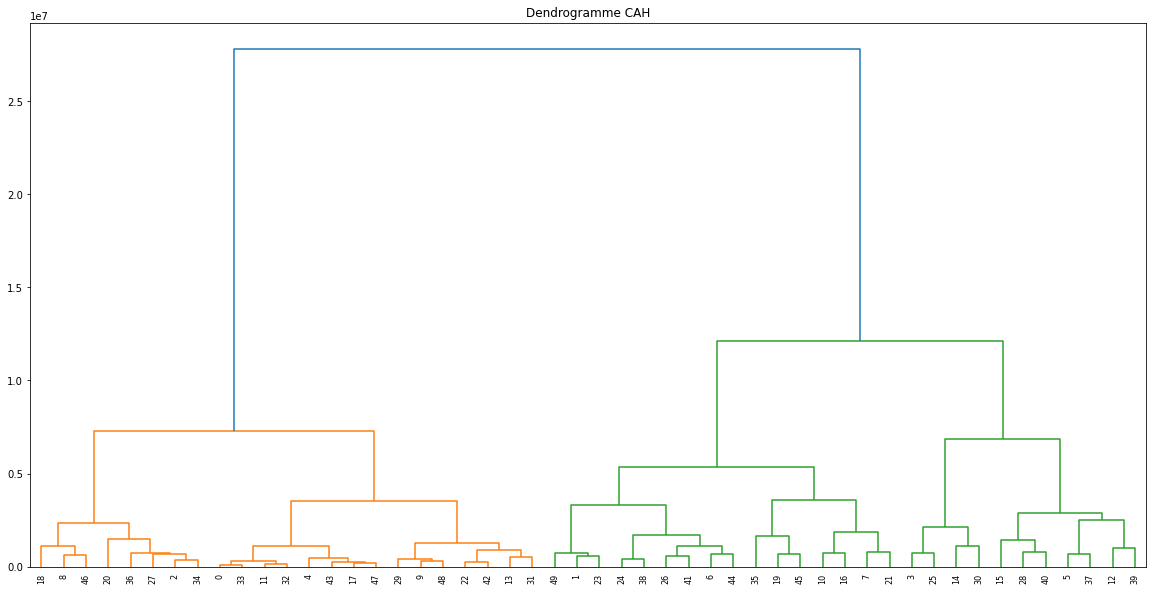

/Users/sooyounglee/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,nb_visites,nb_views,nb_addtocarts,nb_transactions,nb_items_bought,sum_time_second,sum_time_minute,sum_time_hour,mean_time_tran_sec,mean_time_tran_minute,mean_time_tran_hour,kmean1_label,agglo_label,kmean2_label
visitorid,,,,,,,,,,,,,,
1165148,858,802.0,29.0,23.0,27.0,1.105799e+07,184300.0,3071.66,4.807822e+05,8013.0,133.55,30,1.0,1
899857,528,342.0,114.0,51.0,72.0,1.104369e+07,184062.0,3067.69,2.165430e+05,3609.0,60.15,30,1.0,1
895999,2474,2368.0,56.0,44.0,50.0,1.046182e+07,174364.0,2906.06,2.377685e+05,3963.0,66.05,30,1.0,1
198153,536,494.0,32.0,10.0,10.0,1.038605e+07,173101.0,2885.01,1.038605e+06,17310.0,288.50,14,1.0,1
475172,135,108.0,14.0,8.0,13.0,1.029387e+07,171565.0,2859.41,1.286734e+06,21446.0,357.43,14,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389317,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.00,0,0.0,0
1389318,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.00,0,0.0,0
1389319,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.00,0,0.0,0


In [39]:
### CLUSTERING SUR STATS ###
k1 = KMeans(n_clusters=50).fit(stats)
plt.figure(figsize=(20, 10))
Z = linkage(k1.cluster_centers_, method='ward', metric='euclidean')
plt.title("Dendrogramme CAH")
dendrogram(Z, leaf_rotation=90.)
plt.show()

# AGGLOMERATIVECLUSTERING PAR 3
ac = AgglomerativeClustering(n_clusters = 3).fit(k1.cluster_centers_)
cd = pd.DataFrame(k1.cluster_centers_)

stats['kmean1_label'] = k1.labels_

# DATA CLUSTERING    
for i in list(cd.index):
    stats.loc[stats['kmean1_label'] == cd.index[i], 'agglo_label'] = ac.labels_[i]

# GET NEW CENTROIDS = MEAN OF AGGLO 4 LABELS
new_centroids = stats.groupby('agglo_label').mean()
new_stats = stats.drop(['agglo_label'], axis=1)

k2 = KMeans(n_clusters=3, init=new_centroids)
k2.fit(new_stats)

# Centroids and labels
k2_centroids = k2.cluster_centers_
k2_labels = k2.labels_

stats['kmean2_label'] = k2.labels_
stats

Text(0.5, 1.0, "Le nombre d'ajouts aux paniers par visiteur")

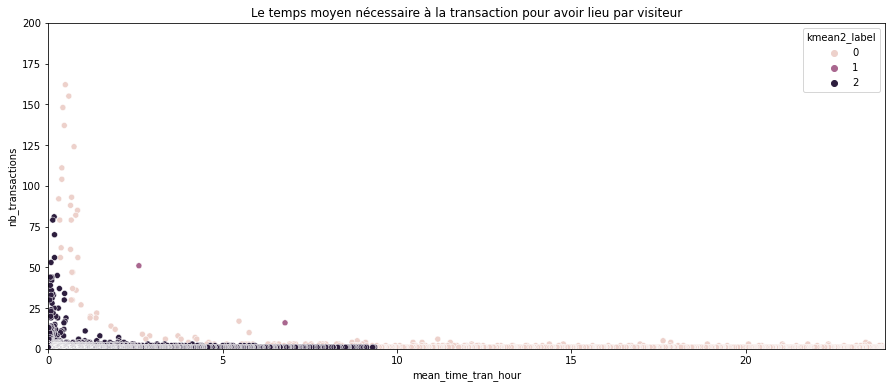

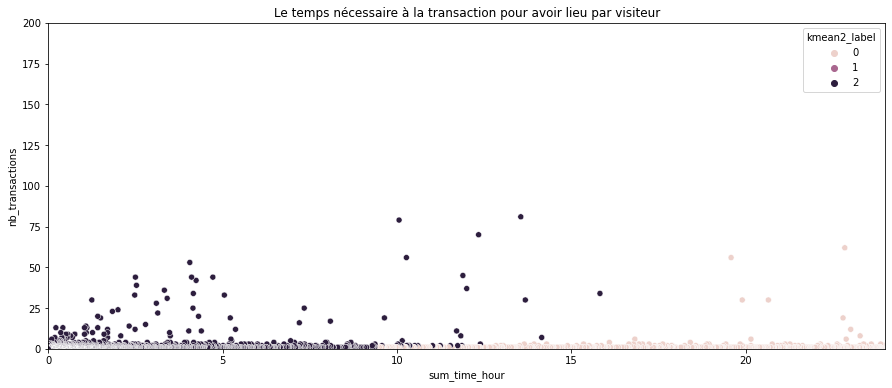

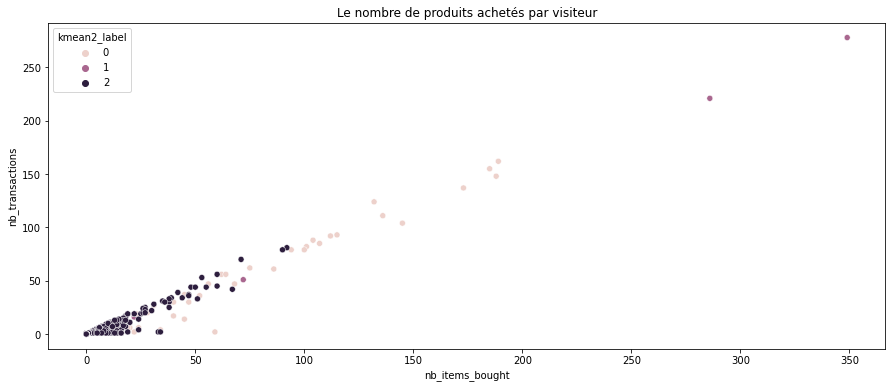

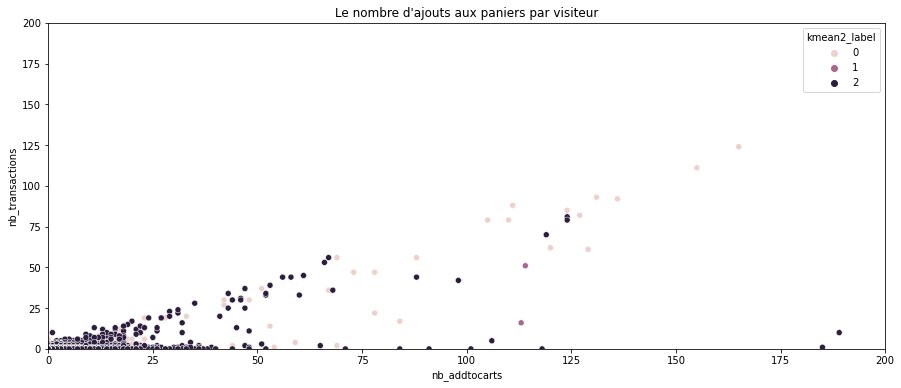

In [47]:
##### VISUALISATION CLUSTERING SUR TABELEAU STATS (PAR VISITEUR) ####
plt.figure(figsize=(15,6))
sns.scatterplot(data=stats.loc[stats.nb_transactions > 0], x="mean_time_tran_hour", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 24)
plt.ylim(0, 200)
plt.title('Le temps moyen nécessaire à la transaction pour avoir lieu par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="sum_time_hour", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 24)
plt.ylim(0, 200)
plt.title('Le temps nécessaire à la transaction pour avoir lieu par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_items_bought", y="nb_transactions", hue="kmean2_label")
#plt.xlim(0, 24)
#plt.ylim(0, 600)
plt.title('Le nombre de produits achetés par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_addtocarts", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.title("Le nombre d'ajouts aux paniers par visiteur")

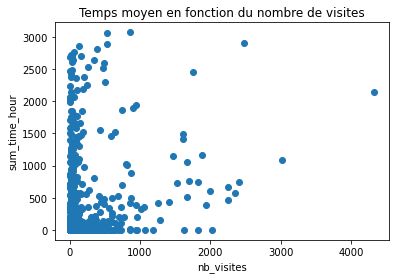

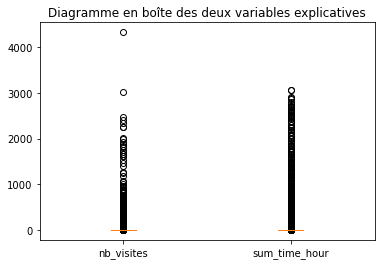

In [41]:
## création d'un nouveau df "stats_1" afin d'afficher un premier mapping
stats_1 = stats[['nb_visites','sum_time_hour']]
stats_1.head()

#affichage du graphique Temps moyen en fonction du nombre de visites
plt.scatter(stats_1['nb_visites'],stats_1['sum_time_hour'])
plt.ylabel('sum_time_hour')
plt.xlabel('nb_visites')
plt.title('Temps moyen en fonction du nombre de visites')  ### C'EST PLUTOT LE TEMPS "TOTAL" que "MOYEN"
plt.show()

#boites à moustaches des deux variables
liste = [stats_1['nb_visites'], stats_1['sum_time_hour']]
plt.figure()
plt.title('Diagramme en boîte des deux variables explicatives')
plt.boxplot(liste, labels = ['nb_visites', 'sum_time_hour'])
plt.show()

In [42]:
### ERREUR A CORRIGER (MELISSA) ####
# Methode des kmeans 
# Algorithme de K-means
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df)

# Centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

#Visualisation des clusters et des centroïdes 
# Liste des couleurs
colors = ["g.","r.","b."]
# Graphique du nuage de points attribués au cluster correspondant
#for i in range(len(stats)):
for i in range (1000):
    plt.plot(stats_1.iloc[i,0], stats_1.iloc[i,1], colors[labels[i]], markersize = 10)
# Graphique des centroïdes
plt.scatter(centroids[:, 0],centroids[:, 1], marker = "o", color = "blue",s=30, linewidths = 1, zorder = 10)
plt.show()
centroidsroids

ValueError: could not convert string to float: 'view'

In [43]:
#### TABLEAU ITEMS ####
# Nombre de visiteurs par itemsid
items = df.groupby('itemid').agg({'visitorid':'count'})
items = items.rename(columns={"visitorid": "nb_visites"})

# Nombre de views par itemid
items_view = df.loc[df['event'] == 'view'].groupby('itemid').agg({'itemid':'count'}) #df.loc[df['itemid'] == 9]
items_view = items_view.rename(columns={"itemid": "nb_views"})

# Nombre de addtocarts par itemid
items_addtocart = df.loc[df['event'] == 'addtocart'].groupby('itemid').agg({'itemid':'count'})
items_addtocart = items_addtocart.rename(columns={"itemid": "nb_addtocarts"})

# Nombre de transactions par itemid
items_transaction = df.loc[df['event'] == 'transaction'].groupby('itemid').agg({'itemid':'count'})
items_transaction = items_transaction.rename(columns={"itemid": "nb_transactions"})

# Merge dataframes
items = pd.merge(items, items_view, left_index=True, right_index=True, how='left')
items = pd.merge(items, items_addtocart, left_index=True, right_index=True, how='left')
items = pd.merge(items, items_transaction, left_index=True, right_index=True, how='left')

# Merge avec temps moyen passé
items = items.fillna(0)
items = items.sort_values('nb_transactions', ascending=False)
items

,nb_visites,nb_views,nb_addtocarts,nb_transactions
itemid,,,,
461686,2978,2539.0,306.0,133.0
119736,893,752.0,44.0,97.0
213834,402,293.0,17.0,92.0
312728,1155,947.0,162.0,46.0
7943,1489,1346.0,97.0,46.0
...,...,...,...,...
159357,1,1.0,0.0,0.0
159359,13,13.0,0.0,0.0
159362,2,2.0,0.0,0.0


In [44]:
### TABLEAU TOP 500 PRODUITS ####
# SELECT 500 PRODUITS PLUS ACHETES, PLUS MIS AU PANIER, PLUS VUS
n_produits = 500

# les n_produits produits plus achetés
top_produits_vendus = items.sort_values(by='nb_transactions', ascending=False).head(n_produits)
top_produits_vendus['cat_top_vendus'] = "1"
top_produits_vendus = top_produits_vendus.drop(columns=['nb_visites', 'nb_views', 'nb_addtocarts'])

# les n_produits produits plus mis au panier
top_produits_paniers = items.sort_values(by='nb_addtocarts', ascending=False).head(n_produits)
top_produits_paniers['cat_top_mis_panier'] = "1"
top_produits_paniers = top_produits_paniers.drop(columns=['nb_visites', 'nb_views', 'nb_transactions'])

# les n_produits produits plus vus
top_produits_vus = items.sort_values(by='nb_views', ascending=False).head(n_produits)
top_produits_vus['cat_top_vus'] = "1"
top_produits_vus = top_produits_vus.drop(columns=['nb_visites', 'nb_addtocarts', 'nb_transactions'])

# Merge les 3 dataframes OUTER
top_produits = pd.merge(top_produits_vendus, top_produits_paniers, left_index=True, right_index=True, how='outer')
top_produits = pd.merge(top_produits, top_produits_vus, left_index=True, right_index=True, how='outer')

top_produits = top_produits[['cat_top_vus', 'cat_top_mis_panier', 'cat_top_vendus']]
top_produits = top_produits.fillna(0)
top_produits

,cat_top_vus,cat_top_mis_panier,cat_top_vendus
itemid,,,
546,1,1,1
829,0,1,1
869,1,1,1
1684,0,0,1
2416,0,1,1
...,...,...,...
465511,1,1,0
465522,0,1,1
465751,0,0,1


In [45]:
top_produits_merged = pd.merge(items, top_produits, left_index=True, right_index=True, how='left')
top_produits_merged = top_produits_merged.sort_values(by=['nb_transactions'], ascending=False)
top_produits_merged = top_produits_merged.fillna(0)
top_produits_merged 

,nb_visites,nb_views,nb_addtocarts,nb_transactions,cat_top_vus,cat_top_mis_panier,cat_top_vendus
itemid,,,,,,,
461686,2978,2539.0,306.0,133.0,1,1,1
119736,893,752.0,44.0,97.0,1,1,1
213834,402,293.0,17.0,92.0,0,1,1
312728,1155,947.0,162.0,46.0,1,1,1
7943,1489,1346.0,97.0,46.0,1,1,1
...,...,...,...,...,...,...,...
442427,47,46.0,1.0,0.0,0,0,0
442428,2,2.0,0.0,0.0,0,0,0
442431,136,133.0,3.0,0.0,0,0,0


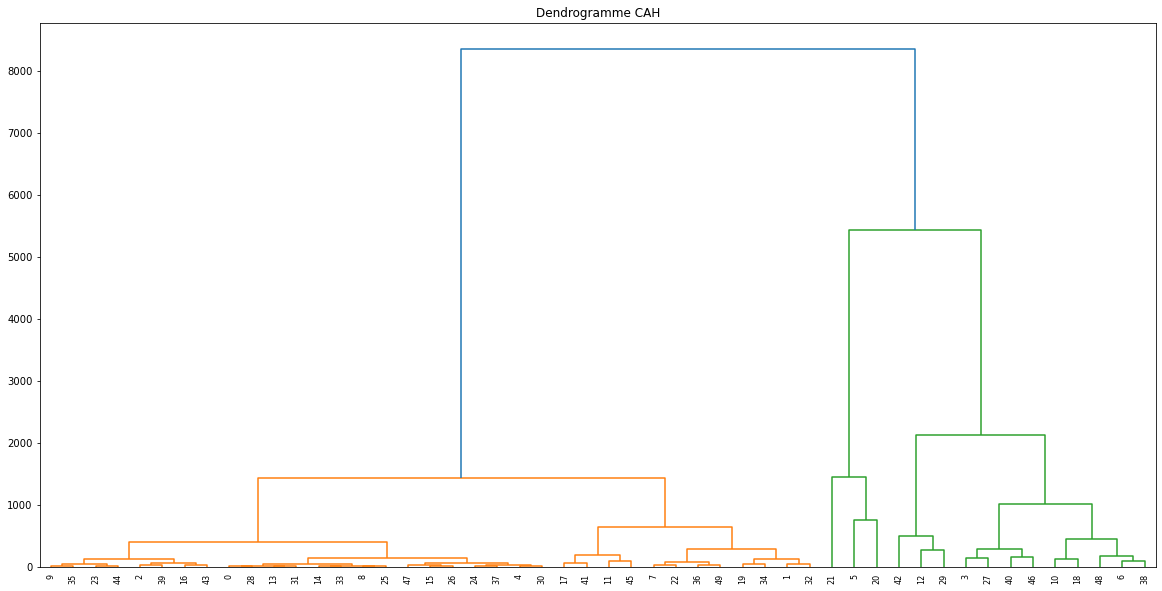

/Users/sooyounglee/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,nb_visites,nb_views,nb_addtocarts,nb_transactions,kmean1_label,agglo_label,kmean2_label
itemid,,,,,,,
461686,2978,2539.0,306.0,133.0,5,2.0,2
119736,893,752.0,44.0,97.0,18,0.0,2
213834,402,293.0,17.0,92.0,32,1.0,0
312728,1155,947.0,162.0,46.0,46,0.0,2
7943,1489,1346.0,97.0,46.0,29,0.0,2
...,...,...,...,...,...,...,...
159357,1,1.0,0.0,0.0,0,1.0,1
159359,13,13.0,0.0,0.0,8,1.0,1
159362,2,2.0,0.0,0.0,28,1.0,1


In [46]:
#### CLUSTERING SUR TABLEAU CI-DESSUS : ITEMS ####
##### A REMPLACER PAR UNE AUTRE METHODE DE CLUSTERING : AGGLO (SADALI) ####

k1 = KMeans(n_clusters=50).fit(items)
plt.figure(figsize=(20, 10))
Z = linkage(k1.cluster_centers_, method='ward', metric='euclidean')
plt.title("Dendrogramme CAH")
dendrogram(Z, leaf_rotation=90.)
plt.show()

# AGGLOMERATIVECLUSTERING PAR 3
ac = AgglomerativeClustering(n_clusters = 3).fit(k1.cluster_centers_)
cd = pd.DataFrame(k1.cluster_centers_)

items['kmean1_label'] = k1.labels_

# DATA CLUSTERING    
for i in list(cd.index):
    items.loc[items['kmean1_label'] == cd.index[i], 'agglo_label'] = ac.labels_[i]

# GET NEW CENTROIDS = MEAN OF AGGLO 4 LABELS
new_centroids = items.groupby('agglo_label').mean()
new_items = items.drop(['agglo_label'], axis=1)

k2 = KMeans(n_clusters=3, init=new_centroids)
k2.fit(new_items)

# Centroids and labels
k2_centroids = k2.cluster_centers_
k2_labels = k2.labels_

items['kmean2_label'] = k2.labels_
items

Text(0.5, 1.0, 'Clustering')

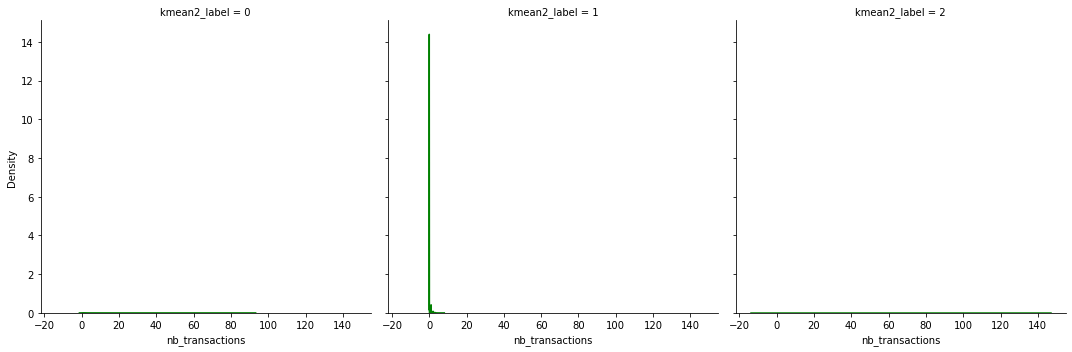

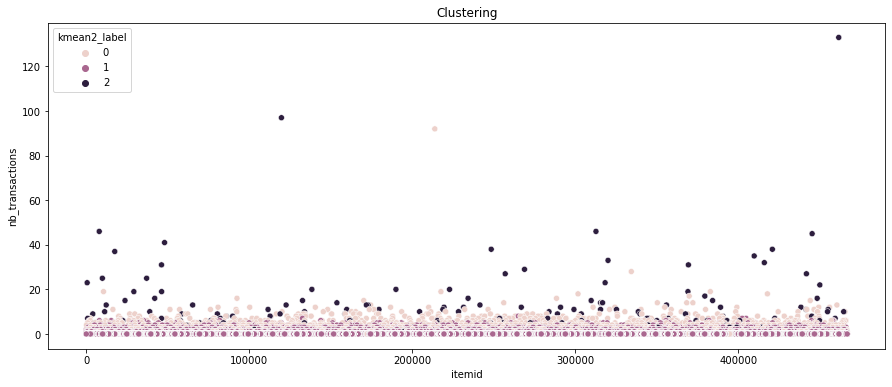

In [48]:
### VISUALISATION RESULTATS CLUSTERING ###
sns.displot(data=items, x="nb_transactions", col="kmean2_label", kind="kde", color='green')

import seaborn as sns
plt.figure(figsize=(15,6))
sns.scatterplot(data=items, y="nb_transactions", x=items.index, hue="kmean2_label",)
plt.title('Clustering')